# CFAR

This is an example of Constant False Alarm Rate (CFAR) threshold for an FMCW radar.
`RadarSimPy` has two buildin CFAR methods: `CA-CFAR` and `OS-CFAR`.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**


## Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

 | Parameter                       | Variable in `RadarSimPy` | Value      |
 |---------------------------------|--------------------------|------------|
 | Center frequency ($f_c$)        | fc                       | 24.125 GHz |
 | Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
 | Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
 | Rising or falling chirp         | slop_type                | rising     |
 | Chirp repetition period ($CRP$) | repetition_period        | 100 us     |
 | Chirp length ($T$)              | pulse_length             | 80 us      |
 | Number of chirps                | pulses                   | 1        |
 | Chirp start delay               | delay                    | 0 s        |

The radiation pattern os the transmitter antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=20,
                 prp=100e-6,
                 pulses=1,
                 channels=[tx_channel])

 ### Receiver
 The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `RadarSimPy` | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | fs                       | 2 Msps       |
 | Noise figure ($NF$)              | noise_figure             | 12 dB        |
 | RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
 | Load resistor ($R_L$)            | load_resistor            | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | baseband_gain            | 30 dB        |

 The radiation pattern os the receiver antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.

In [2]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

rx = Receiver(fs=2e6,
              noise_figure=12,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])

 Create the FMCW radar model based on all the parameters defined above.

In [3]:
radar = Radar(transmitter=tx, receiver=rx)

 Calculate the characteristics of the FMCW radar:

 - Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

 - Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

 - Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

 - Range resolution: $$\delta_r=\frac{c}{2B}$$


In [4]:
print('Maximum range: ', radar.max_range, ' m')
print('Maximum unambiguous speed: ', radar.unambiguous_speed, ' m/s')
print('Range_resolution: ', radar.range_resolution, ' m')

Maximum range:  239.83396640000004  m
Maximum unambiguous speed:  62.133151917098445  m/s
Range_resolution:  1.49896229  m


 ### Targets
 The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (radian).

In [5]:
target_1 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=20, phase=0)
target_2 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=10, phase=0)

targets = [target_1, target_2]

## Simulate Baseband Signals
 
Calculate baseband signal matrix:
$$[channel, slow~time, fast~time]$$
 
#### Simulate with C++ engine

In [6]:
from radarsimpy.simulator import simc

data_cpp = simc(radar, targets)
time_matrix_cpp = data_cpp['timestamp']
data_matrix_cpp = data_cpp['baseband']

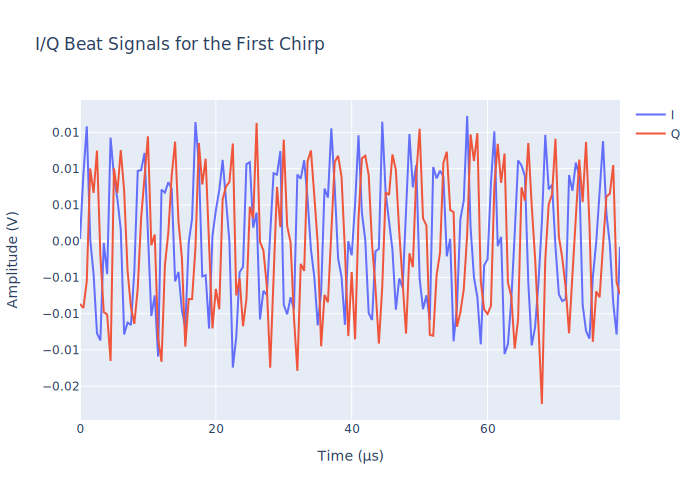

In [7]:
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

beat_I = go.Scatter(
    x=time_matrix_cpp[0, 0, :] * 1e6,
    y=np.real(data_matrix_cpp[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=time_matrix_cpp[0, 0, :] * 1e6,
    y=np.imag(data_matrix_cpp[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Beat Signals for the First Chirp',
    yaxis=dict(tickformat='.2f', title='Amplitude (V)'),
    xaxis=dict(title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

 ## Radar Signal Processing
 ### Range profile

In [8]:
from scipy import signal
import radarsimpy.processing as proc


range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, data_matrix_cpp, range_window)

ca_cfar = proc.cfar_ca(range_profile[0, 0, :], guard=2, trailing=10, pfa=1e-2)
os_cfar = proc.cfar_os(range_profile[0, 0, :], n=20, k=14, pfa=1e-2)

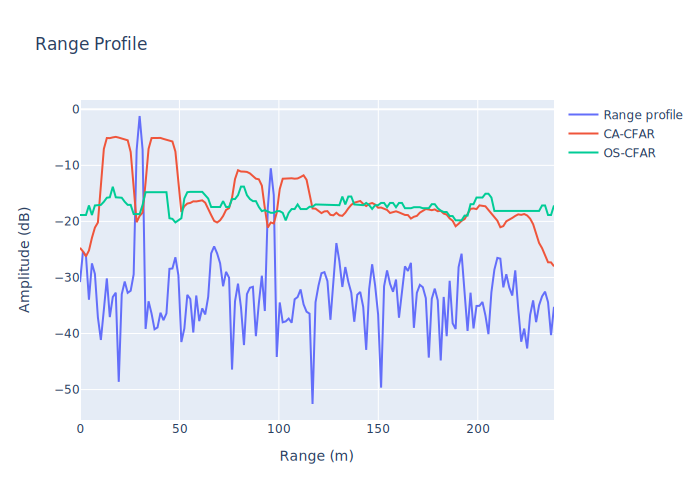

In [9]:
range_axis = np.linspace(
    0, radar.max_range, radar.samples_per_pulse, endpoint=False)

rfft_plot = go.Scatter(
    x=range_axis,
    y=20*np.log10(np.abs(range_profile[0, 0, :])),
    name='Range profile',
)

cacfar_plot = go.Scatter(
    x=range_axis,
    y=20*np.log10(ca_cfar),
    name='CA-CFAR'
)

oscfar_plot = go.Scatter(
    x=range_axis,
    y=20*np.log10(os_cfar),
    name='OS-CFAR'
)

plot_data = [rfft_plot, cacfar_plot, oscfar_plot]

layout = go.Layout(
    title='Range Profile',
    yaxis=dict(title='Amplitude (dB)'),
    xaxis=dict(title='Range (m)'),
)

fig = go.Figure(plot_data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))